# Rating Prediction with Bipartite GNN

## Data Processing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import collections as clt

In [5]:
full_df = pd.read_csv('reviews_anonymized.csv')
full_df

,index,User,Release,Band,Score,Cleansed Text
0,18,0,1011,1645,65,Here we are. The first studio release from Man...
1,22,0,1012,1646,80,"The epic, Tolkien-inspired ""Nightfall In Middl..."
2,26,1,1013,1647,75,"After the first album was released, the fans q..."
3,27,1,1014,1647,95,So comes the third album. Iron Maiden had enjo...
4,28,2,1015,1648,95,This debut LP of early Scandinavian blackmetal...
...,...,...,...,...,...,...
9336,93374,660,1256,1691,54,"In 2003, what would your expectation of a Drea..."
9337,93380,571,1188,2529,94,Another unsung hero from the US metal undergro...
9338,93386,660,1478,1932,60,I don’t think Hammerfall are a very complicate...
9339,93422,571,1352,1823,90,If you ask any metalhead around the world to m...


In [3]:
def isNaN(x):
    return x != x

In [4]:
all_users = full_df['User'].unique()
all_releases = full_df['Release'].unique()
all_genres = [genre_list.split('|') if not isNaN(genre_list) else [] for genre_list in full_df['Combined_Genre'] ]

N_USERS = len(all_users)
N_RELEASES = len(all_releases)

N_USERS, N_RELEASES

(5028, 15583)

In [5]:
import pickle

# genre_group stores a dictionary which maps the original genres into fewer genres
# to reduce computational complexity

with open('genre_group.p', 'rb') as f:
    genre_group = pickle.load(f)
    all_genres = set(genre_group.values())
    genre2idx = {genre:i for i, genre in enumerate(all_genres)}
    N_GENRES = len(all_genres)

N_GENRES, (N_USERS + N_RELEASES) * N_GENRES

(21, 432831)

In [6]:
train_df, test_df = train_test_split(full_df, shuffle=True,random_state=42)
train_df

,index,User,Date,Year,Month,Release,Band,Combined_Genre,Score
61658,86246,3437,May 15 2016,2016,5,8602,20645,heavy metal,63
21768,29264,687,June 28 2008,2008,6,13243,24681,death metal,75
53769,74032,508,April 26 2014,2014,4,19090,20718,us power metal|speed metal|thrash metal,85
2146,2588,112,November 8 2003,2003,11,6539,21370,thrash metal,97
817,960,60,February 16 2003,2003,2,5710,20964,thrash metal,89
...,...,...,...,...,...,...,...,...,...
37194,51180,1751,March 26 2011,2011,3,16538,20699,black metal|progressive metal|folk metal,80
6265,7952,431,January 7 2005,2005,1,5159,20701,symphonic metal,100
54886,75709,4389,July 24 2014,2014,7,19290,28325,thrash metal,80
860,1008,28,February 26 2003,2003,2,5744,20626,heavy metal,63


In [7]:
import torch
from torch_geometric.data import Data
import collections as clt
from tqdm import tqdm

def compute_node_features(df):
    node2genres = [[]] * (N_USERS + N_RELEASES)
    
    print("Processing Node Features")
    for _, row in tqdm(df.iterrows()):
        if not isNaN(row['Combined_Genre']):
            genre_list = list(set([genre_group[x] for x in row['Combined_Genre'].split('|') if x in genre_group]))
            node2genres[row['User']] += genre_list
            node2genres[row['Release']] += genre_list

    node2genres = [clt.Counter(genres) for genres in node2genres]

    X = torch.zeros((N_USERS + N_RELEASES, N_GENRES))

    print("Generating Node Features")
    for i, genres_count in tqdm(enumerate(node2genres)):
        for genre in genres_count:
            X[i][genre2idx[genre]] = genres_count[genre]
    
    return X

node_features = compute_node_features(full_df)

Processing Node Features


65728it [00:02, 32044.95it/s]


Generating Node Features


20611it [00:02, 7656.40it/s]


In [8]:
def process_data(df, X):
    edge_index = []
    edge_target = []
    
    print("Processing Edges and Targets")
    for _, row in tqdm(df.iterrows()):
        edge_index.append([row['User'], row['Release']])
        edge_target.append([row['Score']])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_target = torch.tensor(edge_target, dtype=torch.float)
    data = Data(x=X, edge_index=edge_index, y=edge_target)
    
    return data

In [9]:
from torch_geometric.data import InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, root, df, transform=None, pre_transform=None):
        self.df = df
        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = [process_data(self.df, node_features)]
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

train_dataset = GraphDataset('train',train_df)
test_dataset = GraphDataset('test',test_df)

In [10]:
from torch_geometric.loader import DataLoader

data_size = len(train_dataset)
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE, shuffle=False)

print(f'# Training Samples: {len(train_dataset.y)}')
print(f'# Test Samples: {len(test_loader.dataset.y)}')

# Training Samples: 49296
# Test Samples: 16432


## Define GNN

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GatedGraphConv



class BipartiteGNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size = 64):
        super(BipartiteGNN, self).__init__()
        
        self.gcn_r2u = GCNConv(in_channels, hidden_size)
        self.gcn_u2r = GCNConv(hidden_size, hidden_size)

        self.gated_convs = GatedGraphConv(out_channels=hidden_size, num_layers=4)
        

        self.linear = nn.Linear(hidden_size * 2, out_channels)

    def forward(self, x, edge_index):
        x = self.gcn_r2u(x, edge_index)
        x = F.relu(x)
        x = self.gcn_u2r(x, edge_index[[1, 0]])
        x = F.relu(x)

        x = self.gated_convs(x, edge_index)
        x = F.relu(x)

        u, r = edge_index

        x = torch.cat([x[u], x[r]], dim=1)

        x = self.linear(x)

        return x

model = BipartiteGNN(N_GENRES, 1)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

BipartiteGNN(
  (gcn_r2u): GCNConv(21, 64)
  (gcn_u2r): GCNConv(64, 64)
  (gated_convs): GatedGraphConv(64, num_layers=4)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  47041


In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Train GNN

In [14]:
def train():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(), batch.edge_index)
        loss = loss_fn(pred.squeeze(), batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss /= len(train_loader.dataset)
    return total_loss

def valid():
    model.eval()
    total_loss = 0.0

    for batch in test_loader:
        with torch.no_grad():
            batch.to(device)
            pred = model(batch.x.float(), batch.edge_index)
            loss = loss_fn(pred.squeeze(), batch.y)
            total_loss += loss.item()

    total_loss /= len(test_loader.dataset)

    return total_loss


In [15]:
import warnings
warnings.filterwarnings("ignore")


EPOCHS = 300
print("Starting training...")
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train()
    valid_loss = valid()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} / {EPOCHS} | Train Loss {train_loss:.5f} | Valid Loss {valid_loss:.5f}")


Starting training...
Epoch 0 / 300 | Train Loss 8621991936.00000 | Valid Loss 55772708.00000
Epoch 10 / 300 | Train Loss 563668.25000 | Valid Loss 13994861.00000
Epoch 20 / 300 | Train Loss 60726.67969 | Valid Loss 6547.12646
Epoch 30 / 300 | Train Loss 86053792.00000 | Valid Loss 946871.87500
Epoch 40 / 300 | Train Loss 4006647.00000 | Valid Loss 1274186.25000
Epoch 50 / 300 | Train Loss 184699.93750 | Valid Loss 11823353.00000
Epoch 60 / 300 | Train Loss 182933584.00000 | Valid Loss 29562894.00000
Epoch 70 / 300 | Train Loss 2063816.75000 | Valid Loss 2224338.00000
Epoch 80 / 300 | Train Loss 672640.68750 | Valid Loss 76031.27344
Epoch 90 / 300 | Train Loss 82674.82812 | Valid Loss 8527.51074
Epoch 100 / 300 | Train Loss 33475.71484 | Valid Loss 4689.21387
Epoch 110 / 300 | Train Loss 16677.80859 | Valid Loss 3669.63086
Epoch 120 / 300 | Train Loss 11634.62402 | Valid Loss 3529.27979
Epoch 130 / 300 | Train Loss 9527.71680 | Valid Loss 3526.99121
Epoch 140 / 300 | Train Loss 8367.623

## Visualize Metrics

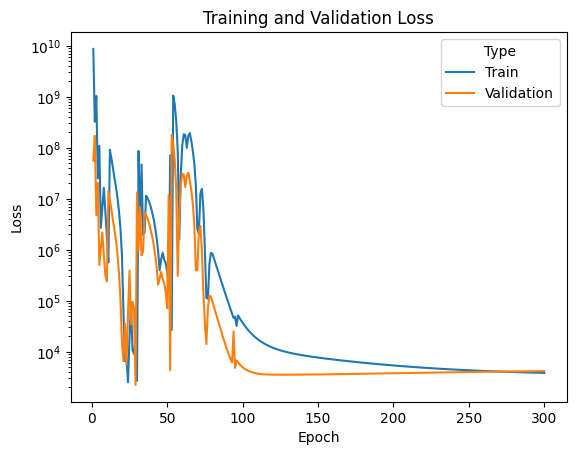

In [16]:
import seaborn as sns

data = {
    'Epoch': list(range(1, len(train_losses) + 1)) * 2,
    'Loss': train_losses + valid_losses,
    'Type': ['Train'] * len(train_losses) + ['Validation'] * len(valid_losses)
}

data_df = pd.DataFrame(data)

sns.lineplot(data=data_df, x='Epoch', y='Loss', hue='Type')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.show()